In [1]:
import time
import uuid

from great_tables import GT, loc, style
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid_utils as uuid_ut

# UUIDs with Python

Python has a built-in library for UUIDs.
But there's a [uuid-utils](https://pypi.org/project/uuid-utils/) library, built in low-level language (Rust) that's about 10 times faster and supports UUID 7, which Python's default doesn't so I wanted to give it a try.


In [2]:
# Original implementation:
print("uuid 1:", uuid.uuid1())
print("uuid 3:", uuid.uuid3(uuid.NAMESPACE_DNS, "Hello, how you do?"))
print("uuid 4:", uuid.uuid4())
print("uuid 5:", uuid.uuid5(uuid.NAMESPACE_DNS, "Hello, how you do?"))

uuid 1: 3f485ede-5846-11f0-ae74-04d3b0d1c8fb
uuid 3: 47981fdb-ea35-39a6-940a-98904125b7e1
uuid 4: 81107f0e-3803-4dc8-a6a9-06837366c696
uuid 5: 99bf4c71-0980-5f0a-9209-d6f8f0d43810


In [3]:
# The rust implementation:
print("uuid 1:", uuid_ut.uuid1())
print("uuid 3:", uuid_ut.uuid3(uuid_ut.NAMESPACE_DNS, "Hello, how you do?"))
print("uuid 4:", uuid_ut.uuid4())
print("uuid 5:", uuid_ut.uuid5(uuid_ut.NAMESPACE_DNS, "Hello, how you do?"))

uuid 1: 3f4b5392-5846-11f0-8c65-bef993646ae8
uuid 3: 47981fdb-ea35-39a6-940a-98904125b7e1
uuid 4: dc10f161-2172-4b0a-9c39-3ec9f4487321
uuid 5: 99bf4c71-0980-5f0a-9209-d6f8f0d43810


## Quick Comparison

In [4]:
# Number of UUIDs to generate
x = 100000

# Standard uuid.uuid4() timing
start_std = time.perf_counter()
for _ in range(x):
    _ = uuid.uuid4()
end_std = time.perf_counter()
print(f"Standard uuid.uuid4(): {end_std - start_std:.4f} seconds")

# uuid_utils.uuid4() timing
start_ut = time.perf_counter()
for _ in range(x):
    _ = uuid_ut.uuid4()
end_ut = time.perf_counter()
print(f"uuid_utils.uuid4():   {end_ut - start_ut:.4f} seconds")

Standard uuid.uuid4(): 0.6247 seconds
uuid_utils.uuid4():   0.0269 seconds


## Benchmark

Let's benchmark both implementations. I'll do 50 iteration in alternative order (I don't randomize), each iteration has 100K executions of either function. 

Let's start with UUID 4.

In [5]:
def time_uuid_function(fn, label, n_uuids, *args, **kwargs):
    start = time.perf_counter()
    for _ in range(n_uuids):
        _ = fn(*args, **kwargs)
    end = time.perf_counter()
    total_time = end - start
    us_per_uuid = (total_time / n_uuids) * 1_000_000
    return {
        "label": label,
        "uuid_count": n_uuids,
        "time": us_per_uuid # microseconds
    }

def benchmark_uuid(fn_python, fn_rust, label_python, label_rust, n_uuids, n_runs):
    results = []

    for _ in range(n_runs):
        results.append(time_uuid_function(fn_python, label_python, n_uuids))
        results.append(time_uuid_function(fn_rust, label_rust, n_uuids))

    return pd.DataFrame(results)

In [6]:
df_compare_uuid_4 = benchmark_uuid(uuid.uuid4, uuid_ut.uuid4, "uuid4_python", "uuid4_rust", 100_000, 50)

In [7]:
df_compare_uuid_4

,label,uuid_count,time
0,uuid4_python,100000,4.310131
1,uuid4_rust,100000,0.184745
2,uuid4_python,100000,3.796460
3,uuid4_rust,100000,0.250828
4,uuid4_python,100000,5.056643
...,...,...,...
95,uuid4_rust,100000,0.556295
96,uuid4_python,100000,8.827892
97,uuid4_rust,100000,0.457997
98,uuid4_python,100000,7.848134


In [8]:
def summarize_benchmark(df):
    summary = df.groupby(['label'])['time'].agg(
        mean='mean',
        median='median',
        std='std',
        min='min',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75),
        max='max'
    ).reset_index()
    return summary

In [9]:
summary_uuid_4 = summarize_benchmark(df_compare_uuid_4)

In [10]:
def plot_violin(df, title="UUID Benchmark Violin Plot"):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='label', y='time', inner='box')
    sns.swarmplot(data=df, x='label', y='time', color='k', size=2, alpha=0.5)
    plt.title(title)
    plt.ylabel("Time (µs)")
    plt.xlabel("UUID Generator")
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

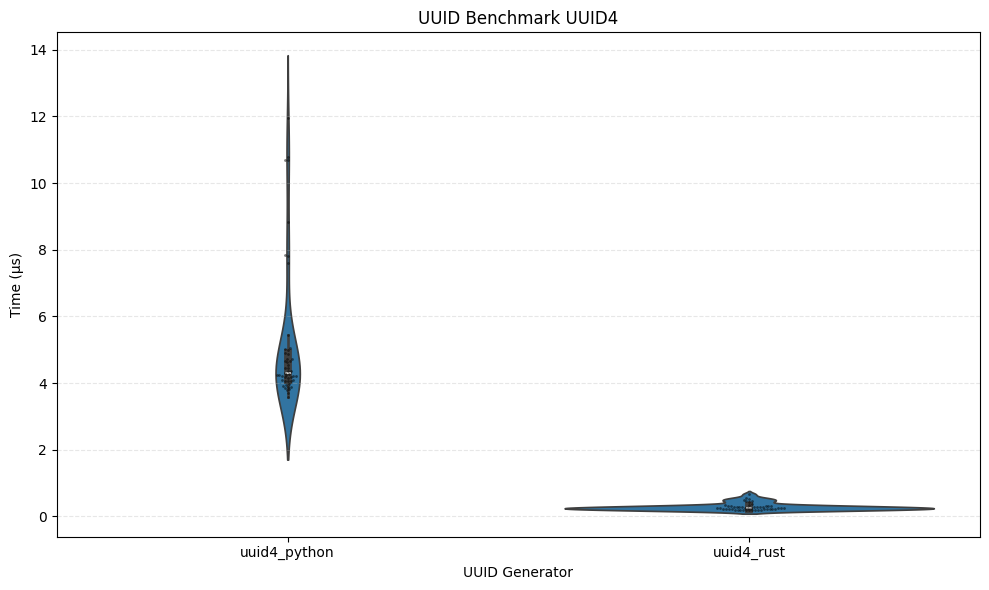

In [11]:
plot_violin(df_compare_uuid_4, title="UUID Benchmark UUID4")

## Compare Them All!

Onlmy UUID versions 1, 3, 4 and 5 exist in both libraries.

In [12]:
def run_all_uuid_benchmarks(n_uuids=100_000, n_runs=50):
    benchmarks = []

    uuid_versions = {
        "uuid1": (
            lambda: uuid.uuid1(), 
            lambda: uuid_ut.uuid1()
        ),
        "uuid3": (
            lambda: uuid.uuid3(uuid.NAMESPACE_DNS, "Benchmarking"),
            lambda: uuid_ut.uuid3(uuid_ut.NAMESPACE_DNS, "Benchmarking")
        ),
        "uuid4": (
            lambda: uuid.uuid4(),
            lambda: uuid_ut.uuid4()
        ),
        "uuid5": (
            lambda: uuid.uuid5(uuid.NAMESPACE_DNS, "Benchmarking"),
            lambda: uuid_ut.uuid5(uuid_ut.NAMESPACE_DNS, "Benchmarking")
        )
    }

    for uuid_type, (fn_py, fn_rs) in uuid_versions.items():
        df = benchmark_uuid(
            fn_python=fn_py,
            fn_rust=fn_rs,
            label_python=f"{uuid_type}_python",
            label_rust=f"{uuid_type}_rust",
            n_uuids=n_uuids,
            n_runs=n_runs
        )
        df["uuid_type"] = uuid_type
        benchmarks.append(df)

    return pd.concat(benchmarks, ignore_index=True)

In [13]:
df_all = run_all_uuid_benchmarks()

In [14]:
df_all["library"] = df_all["label"].apply(lambda x: "python" if "python" in x else "rust")
df_all["uuid_type"] = df_all["label"].str.extract(r"(uuid\d)")

In [15]:
df_all.head(2)

,label,uuid_count,time,uuid_type,library
0,uuid1_python,100000,5.934330,uuid1,python
1,uuid1_rust,100000,0.564869,uuid1,rust


In [16]:
def plot_violin_all(df, title="UUID Benchmark — Python vs. Rust implementation"):
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x='uuid_type', y='time', hue='library', split=False, inner='box', palette="Set3")
    sns.swarmplot(data=df, x='uuid_type', y='time', hue='library', dodge=True, size=2, alpha=0.4, legend=False, palette="Set3")
    plt.title(title)
    plt.ylabel("Time per UUID (μs)")
    plt.xlabel("UUID Version")
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("comparison_plot.png", dpi=300)
    plt.show()



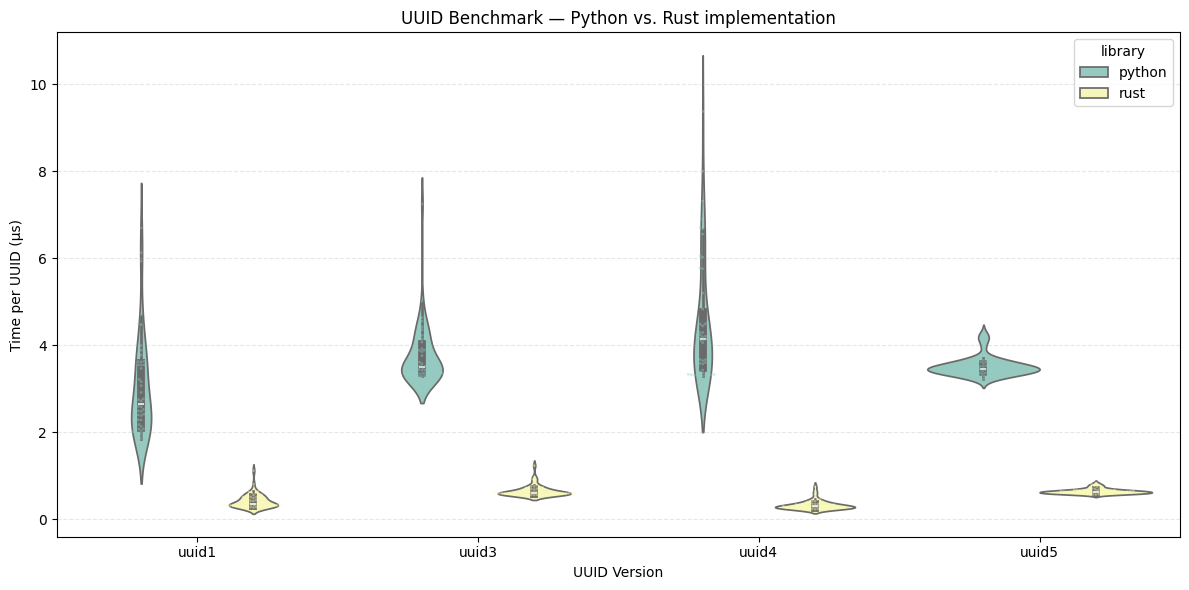

In [17]:
plot_violin_all(df_all)

In [18]:
summary_all = summarize_benchmark(df_all)
summary_all["uuid_type"] = summary_all["label"].str.extract(r"(uuid\d)")
summary_all["library"] = summary_all["label"].apply(lambda x: "🐍 Python" if "python" in x else "🦀 Rust")
summary_all = summary_all[["uuid_type", "library", "mean", "median", "std", "min", "q1", "q3", "max"]]

In [19]:
summary_table = GT(summary_all.round(2), rowname_col ="library", groupname_col="uuid_type"
   ).tab_header(title="UUID implementations - 🐍 Python std. lib vs uuid-utils (Rust 🦀)", subtitle="Units: µs | 50 alternative iterations, average of 100K repetions")
#    ).data_color(
#         domain=[0, 7],
#         palette=["#77DD77", "white", "#FF6961"],
#         na_color="white",
#     ).tab_style(
#         style=style.fill(color="#E8EAF5"),
#         locations=loc.body(columns="std"),
#     ).tab_style(
#         style=style.text(color="black"),
#         locations=loc.body(columns="std"),
#     )


In [20]:
summary_table.save("comparison_table.png", scale=10)

GT(_tbl_data=  uuid_type   library  mean  median   std   min    q1    q3   max
0     uuid1  🐍 Python  3.02    2.66  1.13  1.86  2.10  3.60  6.70
1     uuid1    🦀 Rust  0.42    0.36  0.16  0.27  0.31  0.51  1.12
2     uuid3  🐍 Python  3.75    3.50  0.67  3.29  3.35  4.04  7.25
3     uuid3    🦀 Rust  0.66    0.60  0.13  0.56  0.58  0.69  1.24
4     uuid4  🐍 Python  4.51    4.14  1.41  3.30  3.47  4.76  9.38
5     uuid4    🦀 Rust  0.33    0.30  0.10  0.23  0.26  0.35  0.75
6     uuid5  🐍 Python  3.52    3.46  0.22  3.22  3.39  3.56  4.27
7     uuid5    🦀 Rust  0.65    0.64  0.06  0.57  0.60  0.67  0.84, _body=<great_tables._gt_data.Body object at 0x7c117ae528d0>, _boxhead=Boxhead([ColInfo(var='uuid_type', type=<ColInfoTypeEnum.row_group: 3>, column_label='uuid_type', column_align='left', column_width=None), ColInfo(var='library', type=<ColInfoTypeEnum.stub: 2>, column_label='library', column_align='left', column_width=None), ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='mean', column_align='right', column_width=None), ColInfo(var='median', type=<ColInfoTypeEnum.default: 1>, column_label='median', column_align='right', column_width=None), ColInfo(var='std', type=<ColInfoTypeEnum.default: 1>, column_label='std', column_align='right', column_width=None), ColInfo(var='min', type=<ColInfoTypeEnum.default: 1>, column_label='min', column_align='right', column_width=None), ColInfo(var='q1', type=<ColInfoTypeEnum.default: 1>, column_label='q1', column_align='right', column_width=None), ColInfo(var='q3', type=<ColInfoTypeEnum.default: 1>, column_label='q3', column_align='right', column_width=None), ColInfo(var='max', type=<ColInfoTypeEnum.default: 1>, column_label='max', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7c117ae91790>, _spanners=Spanners([]), _heading=Heading(title='UUID implementations - 🐍 Python std. lib vs uuid-utils (Rust 🦀)', subtitle='Units: µs | 50 alternative iterations, average of 100K repetions', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7c117ae91430>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, catego